In [ ]:
%matplotlib inline
import networkx as nx

In [ ]:
def display(g, ranks=None, labels=None):
    if labels is not None:
        node_size = 500
    elif ranks is None:
        labels = None
        node_size = 500
    else:
        labels = {n: "{:.2f}".format(f) for n, f in ranks.items()}
        node_size = [12000 * ranks[i] for i in range(len(g))]

    nx.draw(g, 
        pos=nx.spring_layout(g, seed=6, k=1), 
        labels=labels,
        with_labels=True,
        node_color='cyan',
        width=2,
        font_size=12,
        node_size=node_size,
    )
    
def make_pagerank_graph(N, s=0):
    return nx.generators.gnc_graph(N, nx.DiGraph, s)

def make_labelprop_graph(p_in=0.45, p_out=0.0, s=2):
    return nx.generators.random_partition_graph([6, 5, 4], p_in, p_out, s)

# Graph Algorithms

## PageRank

**Goal:** Rank web pages by "importance".

**Idea:** Rank pages by iteratively simulating behavior of "random" web surfers following links. Most important pages are the ones with the most surfers in the long run.

## PageRank

**Algorithm:**

- Initially, distribute surfers uniformly across all pages.
- At each time step:
  - With probability $\alpha$, follow a random outgoing link. If no outgoing links, jump to random page.
  - With probability $1 - \alpha$, jump to a random page.
- Repeat for fixed number of iterations, or until rank values stabilize. 


*NOTE:* $\alpha$ is usually set to around $0.85$

In [27]:
def pagerank(graph, iterations, alpha=0.85):
    """Naive iterative PageRank.
    """
    N = len(graph)
    
    # Initially, uniformly distribute weight across the graph.
    ranks = {node: (1 / N) for node in graph}
    
    for _ in range(iterations):
        # Each surfer randomly picks a new node with probability (1 - alpha).
        new_rank = {node: (1 - alpha) / N for node in graph}

        # Otherwise, each surfer follows a random link on their current page.
        for node in graph:
            to_distribute = alpha * ranks[node]
            
            if graph.out_degree(node) == 0:
                # No outgoing links. Randomly pick a new page.
                for target in graph:
                    new_rank[target] += to_distribute / N
            else:
                # Distribute rank uniformly among outgoing edges.
                for src, target in graph.out_edges(node):
                    new_rank[target] += to_distribute / graph.out_degree(node)
           
        ranks = new_rank

    return ranks

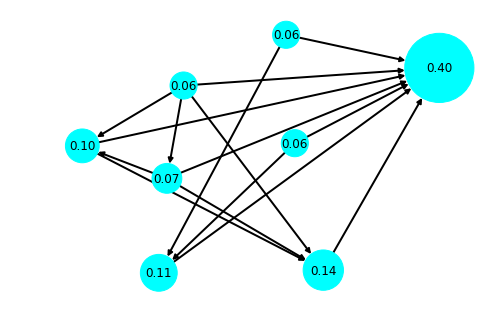

In [32]:
g = make_pagerank_graph(8)
ranks = pagerank(g, iterations=15)
display(g, ranks=ranks)

## Linear Algebra is Cool!

- Mathematically, running PageRank to convergence the stationary vector of the [Markov Chain](https://www.math.ucdavis.edu/~daddel/linear_algebra_appl/Applications/MarkovChain/MarkovChain_9_18/node1.html) whose transition matrix describes the probability of jumping between pages.
- Consequently, another way to compute PageRank is to just find the eigenvalues of the Markov transition matrix!

In [33]:
nx.pagerank_numpy??

## Label Propagation

**Goal:** Compute connected components of a graph.

**Idea:** Give every node a unique, ordered label. Flow the labels through the graph, overwriting smaller values with larger values. When the process stops, every node within a component will have the same label.

In [34]:
from itertools import count, islice

def label_prop(graph, max_iterations, max_edges=10000):
    """Compute connected components of ``graph`` via label propagation.
    """
    labels = {node: i for (i, node) in enumerate(graph)}
    
    for i in range(max_iterations):
        converged = True
    
        for source, dest in islice(graph.edges, max_edges):
            if labels[source] != labels[dest]:
                # Set both labels
                to_keep = min(labels[source], labels[dest])
                labels[source] = to_keep
                labels[dest] = to_keep
                
                # Mark that we're not yet done.
                converged = False
                
        if converged:
            break
            
    return labels

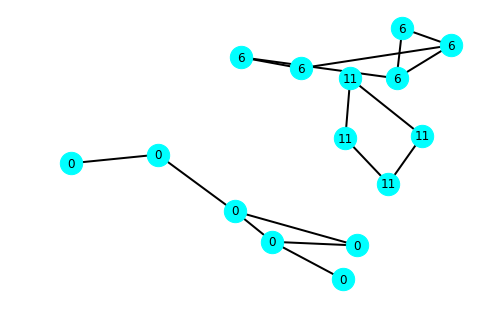

In [40]:
g = make_labelprop_graph()
labels = label_prop(g, max_iterations=2, max_edges=15)
display(g, labels=labels)